In [ ]:
#!pip install biobss
#!pip uninstall matplotlib
#!pip install --upgrade matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import neurokit2 as nk
import biobss
import math

from Modules.Feature_Extraction import *

D:\Semester4\Guided Research\guided research\venv\lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit('float64(float64[:], int32)')


## Read Preprocessed Data

In [2]:
def read_csv(filepath):
    signals = pd.read_csv(filepath, sep=',', header=None)

    return signals.to_numpy()


ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.csv')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.csv')

#fs = read_csv('Preprocessed_data/fs/fs.csv')
fs  = [62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725]

### Crop segments of the signals to remove a few minutes from the start and end
At the very beginning or the end, the device is being attatched? removed from the pateint hence leading to a high variance in signals

In [3]:
#remove first and last few minutes

ecg_filt_cropped = []
for i in range(len(ecg_filt)):
    ecg_filt_cropped.append(ecg_filt[i][5000:763000])

ecg_cropped = []
for i in range(len(ecg)):
    ecg_cropped.append(ecg[i][5000:763000])

### Divide signals from patients into chunks of 10 seconds

In [194]:
duration = int(20*62.4725)
segments_ecg = []

for patient in range(len(ecg_filt_cropped)):
    values = ecg_filt_cropped[patient]
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg.append(values[i : (i + duration)])

## Feature extraction from the temporal domain
Morphological/time domain features are commonly used to train the machine learning modelsWe will extract some of the common ECG features in the literature. Some features can be calculated using only R-peak locations while others requires information on the other fiducial points (P, Q, S and T waves).

#### Features from R peaks

The ___from_Rpeaks___ function calculates morphological features using R-peak locations. These features are:

'RR1': Current RR interval
'RRm': Mean of RR0, RR1 and RR2

#### Features from P, Q, R, S, T waves

The ___from_waves___ function calculates morphological features using locations of P, Q, R, S, T waves. These features are:

't_PR': Time between P and R peak locations
't_QS': Time between Q and S peak locations
't_QT':Time between Q and T peak locations
't_PT_QS': Ratio of t_PT to t_QS
't_QT_QS': Ratio of t_QT to t_QS

In [195]:
def find_features(signal, sampling_rate):
    #Filter ECG signal by using predefined filters
    filtered_ecg=biobss.preprocess.filter_signal(signal, sampling_rate=sampling_rate, signal_type='ECG', method='pantompkins')

    #Detect peaks using 'pantompkins' method.
    locs_peaks=biobss.ecgtools.ecg_detectpeaks(signal,sampling_rate,'pantompkins')

    #Delineate ECG signal using 'neurokit2' package.
    _, fiducials = nk.ecg_delineate(ecg_cleaned=filtered_ecg, rpeaks=locs_peaks, sampling_rate=sampling_rate, method='peak')

    p_peaks_locs = fiducials['ECG_P_Peaks']
    q_peaks_locs = fiducials['ECG_Q_Peaks']

    p_peaks_locs = [x for x in p_peaks_locs if (math.isnan(x) == False)]
    q_peaks_locs = [x for x in q_peaks_locs if (math.isnan(x) == False)]
    locs_peaks = [x for x in locs_peaks if (math.isnan(x) == False)]

    #Calculate features from R peaks
    features_rpeaks = biobss.ecgtools.ecg_features.from_Rpeaks(filtered_ecg, locs_peaks, sampling_rate, average=True)
    #features_rpeaks = {k: 0 if math.isnan(v) else v for k, v in features_rpeaks.items() }

    #Calculate features from P, Q, R, S, T waves
    features_waves = biobss.ecgtools.ecg_features.from_waves(filtered_ecg, locs_peaks, fiducials, sampling_rate, average = True)
    # for i in range(len(features_waves)):
    #     features_waves[i] = {k: 0 if math.isnan(v) else v for k, v in features_waves[i].items() }

    return filtered_ecg, locs_peaks, p_peaks_locs, q_peaks_locs, features_rpeaks, features_waves

In [ ]:
sampling_rate = 62

all_filtered_signals = []
all_locs_peaks = []
all_p_peaks_locs = []
all_q_peaks_locs = []
all_features_rpeaks =[]
all_features_waves = []

for i in range(len(segments_ecg)):
    try:
        filtered_ecg, locs_peaks, p_peaks_locs, q_peaks_locs, features_rpeaks, features_waves = find_features(segments_ecg[i], sampling_rate)
        all_filtered_signals.append(filtered_ecg)
        all_locs_peaks.append(locs_peaks)
        all_p_peaks_locs.append(p_peaks_locs)
        all_q_peaks_locs.append(q_peaks_locs)
        all_features_rpeaks.append(features_rpeaks)
        all_features_waves.append(features_waves)
    except:
        continue

D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
D:\Se

#### Plot one segment to visualize extracted features

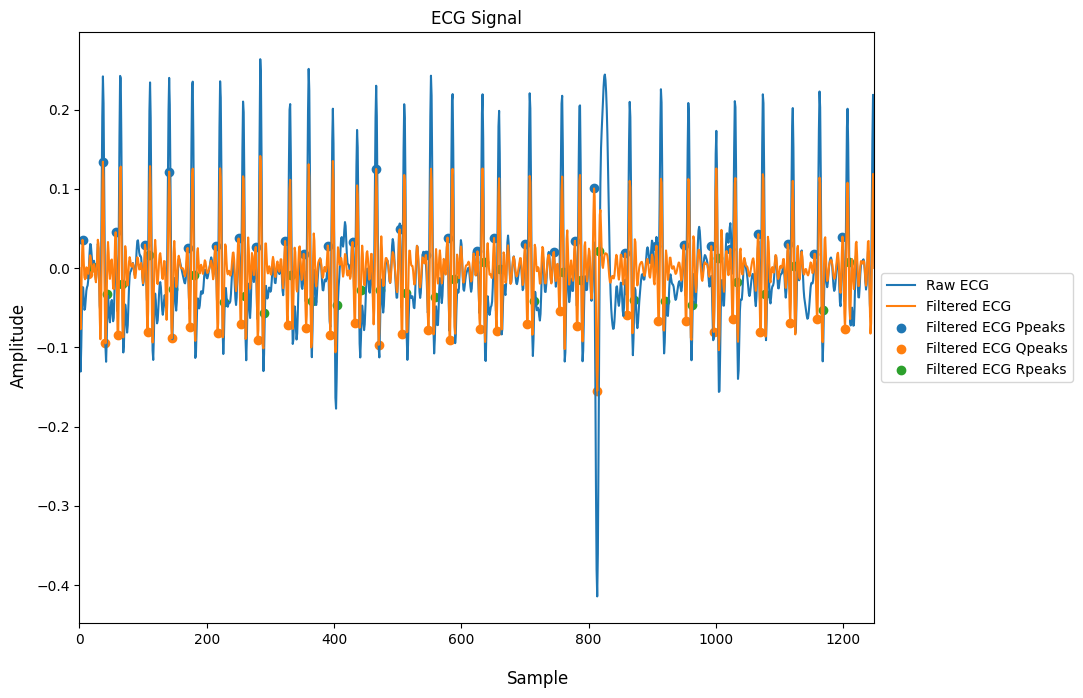

In [197]:
#Generate inputs as dictionaries. The peaks are plotted for raw signal and skipped for filtered signal.
signals={'Raw': segments_ecg[0], 'Filtered': all_filtered_signals[0]}
peaks={'Filtered': {'Ppeaks':all_p_peaks_locs[0], 'Qpeaks': all_q_peaks_locs[0], 'Rpeaks': all_locs_peaks[0]}}

#Plot ECG signal
biobss.ecgtools.plot_ecg(signals=signals, peaks=peaks, show_peaks=True, figsize=(11, 7))

### Extracting relevant features into a dataframe

In [198]:
features_waves_df = pd.DataFrame(all_features_waves)
features_waves_df  = features_waves_df.fillna(0)
features_waves_reduced = features_waves_df[["ecg_t_PR", "ecg_t_QS", "ecg_t_QT", "ecg_t_PT_QS", "ecg_t_QT_QS"]]

features_rpeaks_df = pd.DataFrame(all_features_rpeaks)
features_rpeaks_df  = features_rpeaks_df.fillna(0)
features_repaks_reduced = features_rpeaks_df[["ecg_RR1", "ecg_RRm"]]

features_waves_reduced["ecg_RR1"] = features_rpeaks_df[["ecg_RR1"]]
features_waves_reduced["ecg_RRm"] = features_rpeaks_df[["ecg_RRm"]]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10516\416358668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_waves_reduced["ecg_RR1"] = features_rpeaks_df[["ecg_RR1"]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10516\416358668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_waves_reduced["ecg_RRm"] = features_rpeaks_df[["ecg_RRm"]]


### Clustering using DBSCAN
DBSCAN requires only two parameters: epsilon and minPoints. Epsilon is the radius of the circle to be created around each data point to check the density and minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.

In [205]:
clustering = DBSCAN(eps=1, min_samples=30).fit(features_waves_reduced)
DBSCAN_dataset = features_waves_reduced.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
-1,20


In [206]:
y_pred = clustering.fit_predict(features_waves_reduced)

anomoly_indices = np.where(y_pred == -1)[0]

anomolous_signals = np.take(features_waves_df, anomoly_indices, 0)
anomolous_signals

,ecg_t_PR,ecg_t_QR,ecg_t_RS,ecg_t_RT,ecg_t_PQ,ecg_t_PS,ecg_t_PT,ecg_t_QS,ecg_t_QT,ecg_t_ST,...,ecg_a_RS_QR,ecg_a_PQ_QS,ecg_a_PQ_QT,ecg_a_PQ_PS,ecg_a_PQ_QR,ecg_a_PQ_RS,ecg_a_RS_QS,ecg_a_RS_QT,ecg_a_ST_PQ,ecg_a_ST_QT
0,0.176915,0.112399,0.060484,0.182964,0.064516,0.237399,0.359879,0.172883,0.295363,0.122480,...,-0.290519,-1.593476,-1.074919,1.606378,-2.649351,-4.597450,0.303074,-0.250468,-0.851402,0.759374
1,0.158602,0.086022,0.059677,0.165054,0.072581,0.218280,0.323656,0.145699,0.251075,0.105376,...,-0.444173,3.582338,-1.104641,1.184275,-2.846117,1.265091,4.230403,-0.497704,-0.995675,0.914639
2,0.168851,0.096270,0.056452,0.168347,0.072581,0.225302,0.337198,0.152722,0.264617,0.111895,...,-1.106903,7.064348,-1.004018,1.284079,-2.578457,-0.838100,6.345169,-0.503832,-1.212782,0.973356
3,0.176882,0.104301,0.060753,0.170430,0.072581,0.237634,0.347312,0.165054,0.274731,0.109677,...,-0.468759,8.189148,-1.053545,1.396670,-2.401922,-178.638046,7.441573,-0.420942,-1.031106,0.876033
4,0.173998,0.108993,0.071359,0.183773,0.065005,0.245357,0.357771,0.180352,0.292766,0.112414,...,-0.519245,0.479441,-0.952457,1.003431,-1.897882,-0.905958,1.492137,-0.775352,-1.308552,1.133899
5,0.169355,0.109375,0.073589,0.169859,0.059980,0.242944,0.339214,0.182964,0.279234,0.096270,...,3.566428,0.351819,-0.942847,2.174043,-5.150252,0.670261,1.718887,-0.356771,-0.974825,0.890517
6,0.170304,0.111006,0.074953,0.175047,0.059298,0.245256,0.345351,0.185958,0.286053,0.100095,...,1.322669,-1.387904,-0.988754,-3.140230,-0.610301,-2.101661,-0.068174,-0.764346,-1.537675,1.270814
7,0.162442,0.091014,0.052995,0.163018,0.071429,0.215438,0.325461,0.144009,0.254032,0.110023,...,1.290445,2.162376,-0.973635,1.121377,-1.130679,2.672330,2.149456,-0.533493,-1.975589,0.975664
8,0.175464,0.112903,0.072336,0.192571,0.062561,0.247801,0.368035,0.185239,0.305474,0.120235,...,0.894855,0.596772,-0.990189,1.809358,0.707686,26.194531,1.947823,-0.698646,-1.545095,1.081049
9,0.175403,0.106351,0.075101,0.193044,0.069052,0.250504,0.368448,0.181452,0.299395,0.117944,...,-1.020489,-0.404233,-1.109582,-2.278014,-2.529300,-3.212954,1.401629,-0.625299,-1.529574,1.123044


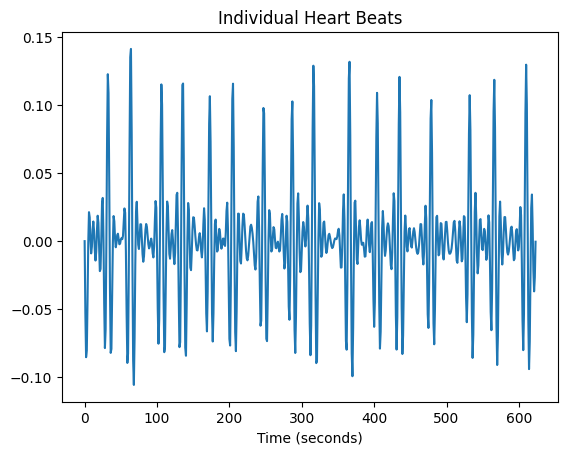

In [190]:
# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# # Aesthetics
# lines = [] # Create empty list to contain the plot of each signal
# colors = {0: "blue", -1: "red"}
ax.plot(all_filtered_signals[anomoly_indices[0]])

### Physiological Limits of Anomolous signals:
The phsyiological limits can be compared to the accepted values in the literature. Reference: https://link.springer.com/book/10.1007/978-3-319-68415-4

These values are defined as constants in the corresponding modules as given below.

Physiological limits:

HR_MIN = 40 #minimum heart rate
HR_MAX = 180 #maximum heart rate
PP_MAX = 3 #maximum peak to peak interval

In [191]:
#Peak detection

for i in range(len(anomoly_indices)):
    locs_peaks=biobss.ecgtools.ecg_detectpeaks(all_filtered_signals[anomoly_indices[i]],sampling_rate,'pantompkins')
    peaks = all_filtered_signals[anomoly_indices[i]][locs_peaks]

    #Check for physiological limits
    info=biobss.sqatools.check_phys(locs_peaks,sampling_rate)
    print("Anomolous Signal "+ str(i))
    print(info)

Anomolous Signal 0
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 1
{'Rule 1': True, 'Rule 2': True, 'Rule 3': True}
Anomolous Signal 2
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 3
{'Rule 1': True, 'Rule 2': True, 'Rule 3': True}
Anomolous Signal 4
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}
Anomolous Signal 5
{'Rule 1': True, 'Rule 2': True, 'Rule 3': False}


#### Template Matching

A common method for signal quality assessment is "Template Matching". This method is based on the expectation that pulse waveforms in an ECG segment will have similar morphology. A template is generated by aligning the pulses by their R-peaks and averaging them. Then, similarity of each pulse with the template is calculated using a measure. The ___template_matching___ function uses Pearson correlation as similarity measure. The function returns a tuple of correlation coefficients and a boolean result for the quality of the segment.

In [192]:
#Template matching
for i in range(len(anomoly_indices)):
    locs_peaks=biobss.ecgtools.ecg_detectpeaks(all_filtered_signals[anomoly_indices[i]],sampling_rate,'pantompkins')
    info=biobss.sqatools.template_matching(all_filtered_signals[anomoly_indices[i]],locs_peaks)
    print("Anomolous Signal "+ str(i))
    print(info[1])


Anomolous Signal 0
False
Anomolous Signal 1
False
Anomolous Signal 2
False
Anomolous Signal 3
False
Anomolous Signal 4
False
Anomolous Signal 5
False
